<a href="https://colab.research.google.com/github/firarru/PySpark/blob/main/Assesmen_CLO3_Kelompok_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# pip install pyspark

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [4]:
url = "https://raw.githubusercontent.com/firarru/PySpark/refs/heads/main/Dataset/adult.data"

df = pd.read_csv(url, header=None)
df.to_csv("adult.data", index=False, header=None)
spark = SparkSession.builder.appName("Adult Data Analysis").getOrCreate()

In [5]:
# Membuat schema untuk dataset
schema = StructType([
    StructField("age", IntegerType(), True),
    StructField("workclass", StringType(), True),
    StructField("fnlwgt", IntegerType(), True),
    StructField("education", StringType(), True),
    StructField("education_num", IntegerType(), True),
    StructField("marital_status", StringType(), True),
    StructField("occupation", StringType(), True),
    StructField("relationship", StringType(), True),
    StructField("race", StringType(), True),
    StructField("sex", StringType(), True),
    StructField("capital_gain", IntegerType(), True),
    StructField("capital_loss", IntegerType(), True),
    StructField("hours_per_week", IntegerType(), True),
    StructField("native_country", StringType(), True),
    StructField("income", StringType(), True)
])

In [6]:
# Membaca file adult.data
df = spark.read.csv("adult.data", schema=schema, header=False, inferSchema=True)

df.show(5)
df.printSchema()
df.describe().show()

+---+-----------------+------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|age|        workclass|fnlwgt| education|education_num|     marital_status|        occupation|  relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+-----------------+------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
| 39|        State-gov| 77516| Bachelors|           13|      Never-married|      Adm-clerical| Not-in-family| White|   Male|        2174|           0|            40| United-States| <=50K|
| 50| Self-emp-not-inc| 83311| Bachelors|           13| Married-civ-spouse|   Exec-managerial|       Husband| White|   Male|           0|           0|            13| United-States| <=50K|
| 38|          Private|215646|   HS-grad|            9|     

In [7]:
df.count()

32561

In [8]:
# Menghitung jumlah nilai NULL atau '?' di setiap kolom
missing_values = df.select([sum(when(col(c).isNull() | (col(c) == "NULL") | (col(c) == " ?"), 1).otherwise(0)).alias(c) for c in df.columns])

missing_values.show()

+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|education|education_num|marital_status|occupation|relationship|race|sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|  0|     1836|     0|        0|            0|             0|      1843|           0|   0|  0|           0|           0|             0|           583|     0|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+



In [9]:
df = df.filter(
    ~(
        col("age").isNull() |
        (trim(col("workclass")) == " ?") |
        col("workclass").isNull() |
        (trim(col("education")) == " ?") |
        col("education").isNull() |
        # Tambahkan kolom lainnya sesuai kebutuhan
        (trim(col("occupation")) == " ?") |
        col("occupation").isNull()
    )
)
df.count()

32561

In [10]:
# df = df.drop()
# df.count()

In [11]:
df.show()

+---+-----------------+------+-------------+-------------+--------------------+------------------+--------------+-------------------+-------+------------+------------+--------------+--------------+------+
|age|        workclass|fnlwgt|    education|education_num|      marital_status|        occupation|  relationship|               race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+-----------------+------+-------------+-------------+--------------------+------------------+--------------+-------------------+-------+------------+------------+--------------+--------------+------+
| 39|        State-gov| 77516|    Bachelors|           13|       Never-married|      Adm-clerical| Not-in-family|              White|   Male|        2174|           0|            40| United-States| <=50K|
| 50| Self-emp-not-inc| 83311|    Bachelors|           13|  Married-civ-spouse|   Exec-managerial|       Husband|              White|   Male|           0|           0|            1

In [12]:
df.columns

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education_num',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'native_country',
 'income']

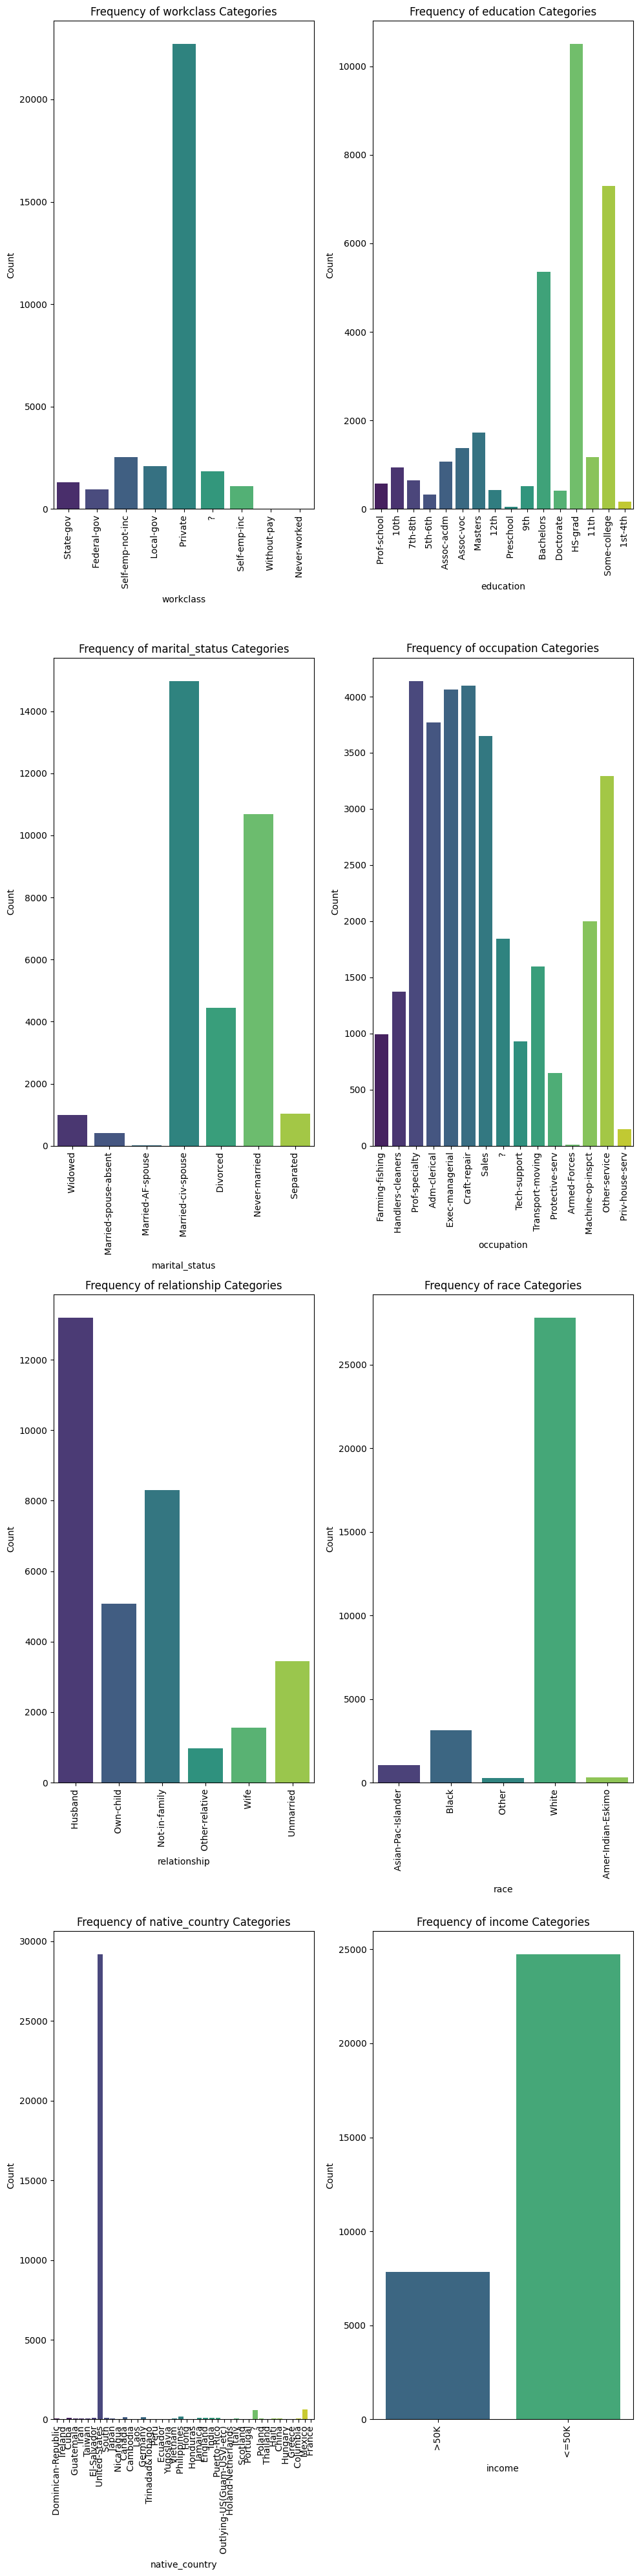

In [13]:
# Daftar kolom kategorik yang ingin dianalisis
categorical_columns = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'native_country', 'income']

# Membagi kolom menjadi dua kelompok (sesuai jumlah subplot yang tersedia)
group1 = categorical_columns[:4]  # Kolom pertama sampai keempat
group2 = categorical_columns[4:]  # Kolom kelima sampai kedelapan

# Membuat figure dan axes untuk 4 baris dan 2 kolom
fig, axes = plt.subplots(4, 2, figsize=(10, 40))  # 4 baris, 2 kolom

# Looping untuk kelompok pertama
for i, column in enumerate(group1):
    counts = df.groupBy(column).count()
    counts_pd = counts.toPandas()
    sns.barplot(x=column, y="count", data=counts_pd, ax=axes[i//2, i%2], hue=column, palette="viridis", legend=False)
    axes[i//2, i%2].set_title(f"Frequency of {column} Categories")
    axes[i//2, i%2].set_xlabel(column)
    axes[i//2, i%2].set_ylabel("Count")
    axes[i//2, i%2].tick_params(axis='x', rotation=90)

# Looping untuk kelompok kedua
for i, column in enumerate(group2):
    counts = df.groupBy(column).count()
    counts_pd = counts.toPandas()
    sns.barplot(x=column, y="count", data=counts_pd, ax=axes[(i+4)//2, (i+4)%2], hue=column, palette="viridis", legend=False)
    axes[(i+4)//2, (i+4)%2].set_title(f"Frequency of {column} Categories")
    axes[(i+4)//2, (i+4)%2].set_xlabel(column)
    axes[(i+4)//2, (i+4)%2].set_ylabel("Count")
    axes[(i+4)//2, (i+4)%2].tick_params(axis='x', rotation=90)

# Menampilkan grafik
plt.tight_layout()
plt.show()

<ipython-input-14-b6b738696299>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=column, y="count", data=counts_pd, palette="viridis", ax=axes[0, i])
<ipython-input-14-b6b738696299>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=column, y="count", data=counts_pd, palette="viridis", ax=axes[0, i])
<ipython-input-14-b6b738696299>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=column, y="count", data=counts_pd, palette="viridis", ax=axes[0, i])
<ipython-input-14-b6b738696299>:15: FutureWarning: 

Passing `palette` without assigning

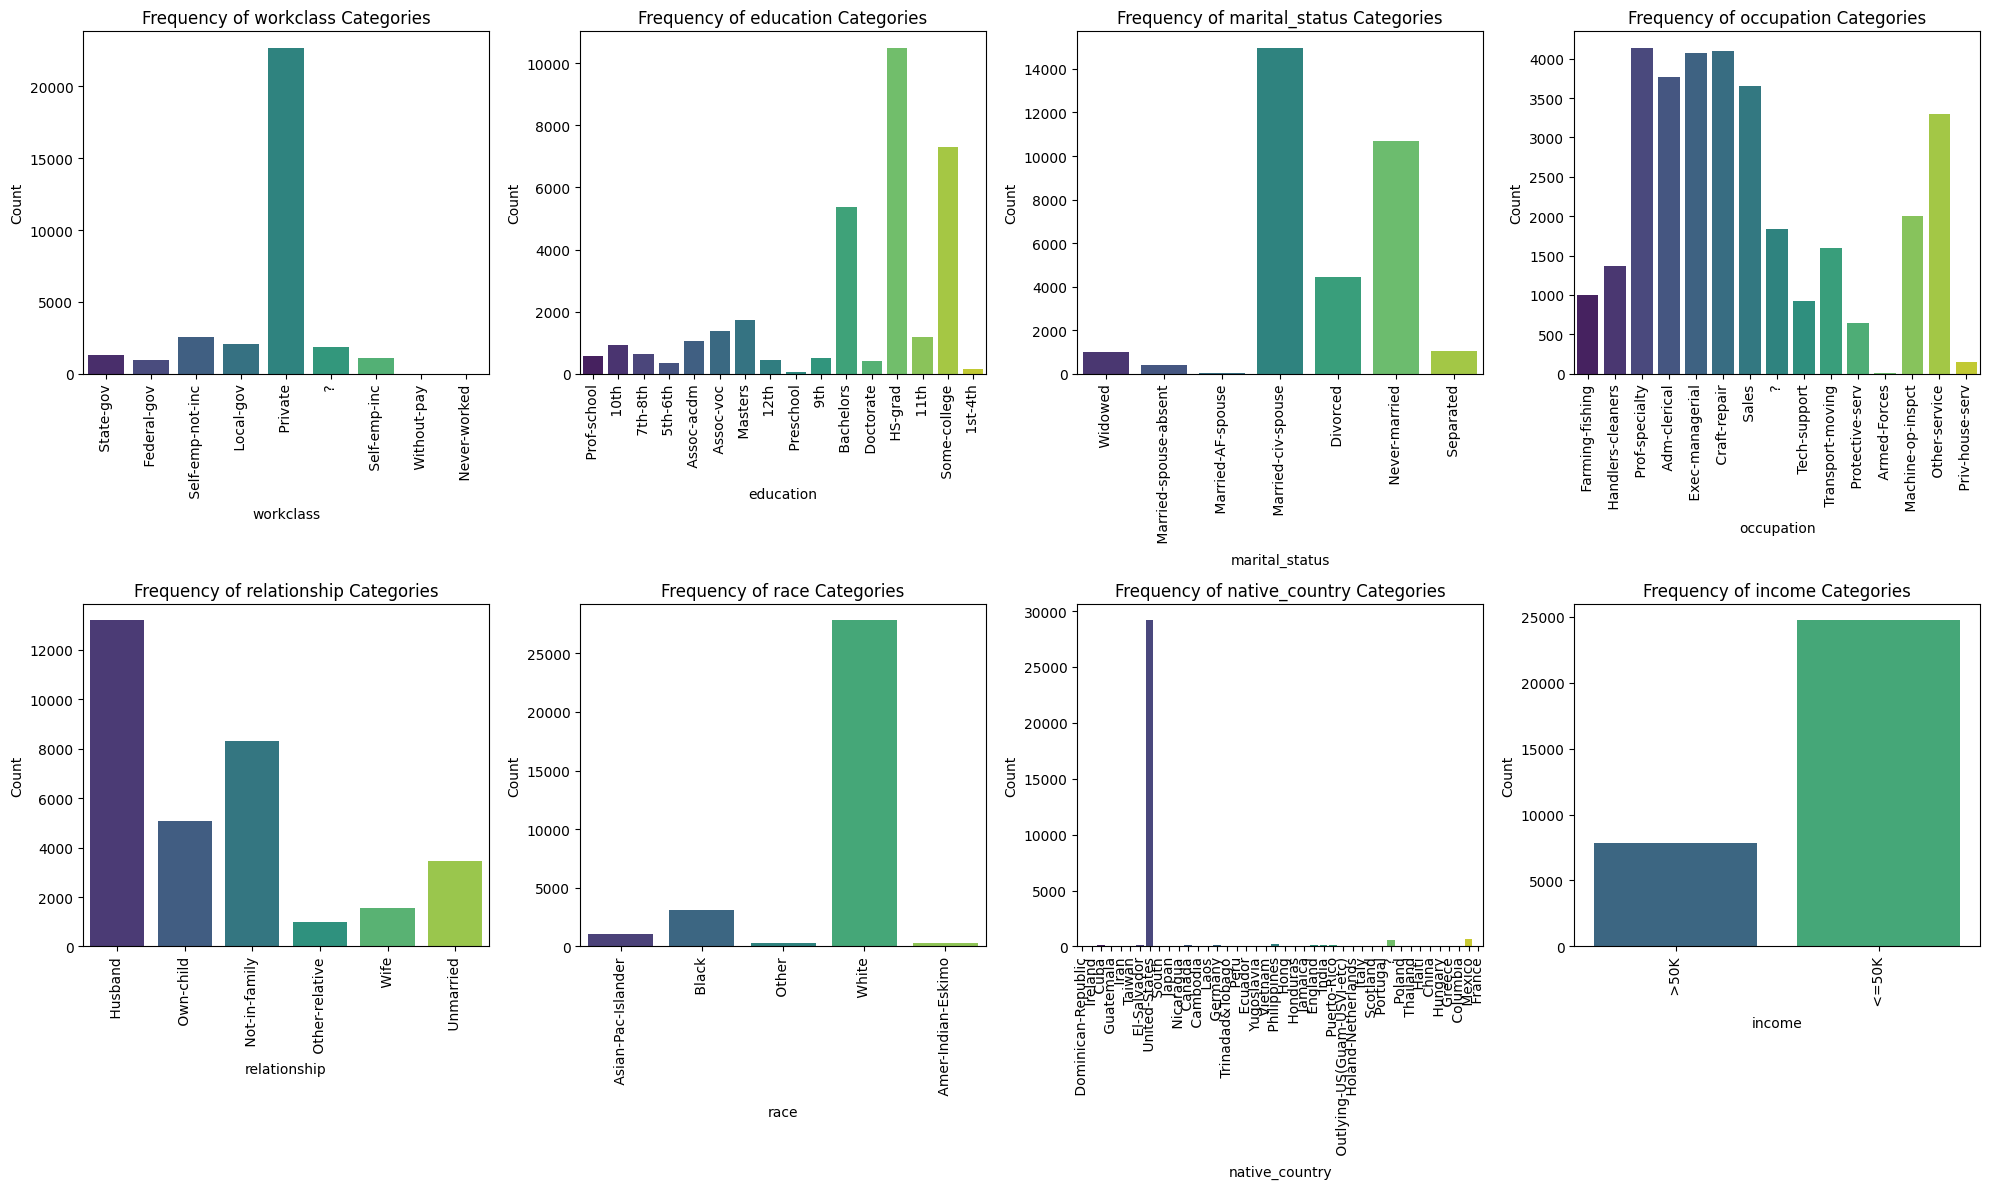

In [14]:
# Daftar kolom kategorik yang ingin dianalisis
categorical_columns = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'native_country', 'income']

# Membagi kolom menjadi dua kelompok (sesuai jumlah subplot yang tersedia)
group1 = categorical_columns[:4]  # Kolom pertama sampai keempat
group2 = categorical_columns[4:]  # Kolom kelima sampai kedelapan

# Membuat figure dan axes untuk 2 baris dan 4 kolom
fig, axes = plt.subplots(2, 4, figsize=(20, 12))  # 2 baris, 4 kolom

# Looping untuk kelompok pertama
for i, column in enumerate(group1):
    counts = df.groupBy(column).count()
    counts_pd = counts.toPandas()
    sns.barplot(x=column, y="count", data=counts_pd, palette="viridis", ax=axes[0, i])
    axes[0, i].set_title(f"Frequency of {column} Categories")
    axes[0, i].set_xlabel(column)
    axes[0, i].set_ylabel("Count")
    axes[0, i].tick_params(axis='x', rotation=90)

# Looping untuk kelompok kedua
for i, column in enumerate(group2):
    counts = df.groupBy(column).count()
    counts_pd = counts.toPandas()
    sns.barplot(x=column, y="count", data=counts_pd, palette="viridis", ax=axes[1, i])
    axes[1, i].set_title(f"Frequency of {column} Categories")
    axes[1, i].set_xlabel(column)
    axes[1, i].set_ylabel("Count")
    axes[1, i].tick_params(axis='x', rotation=90)

# Menampilkan grafik
plt.tight_layout()
plt.show()


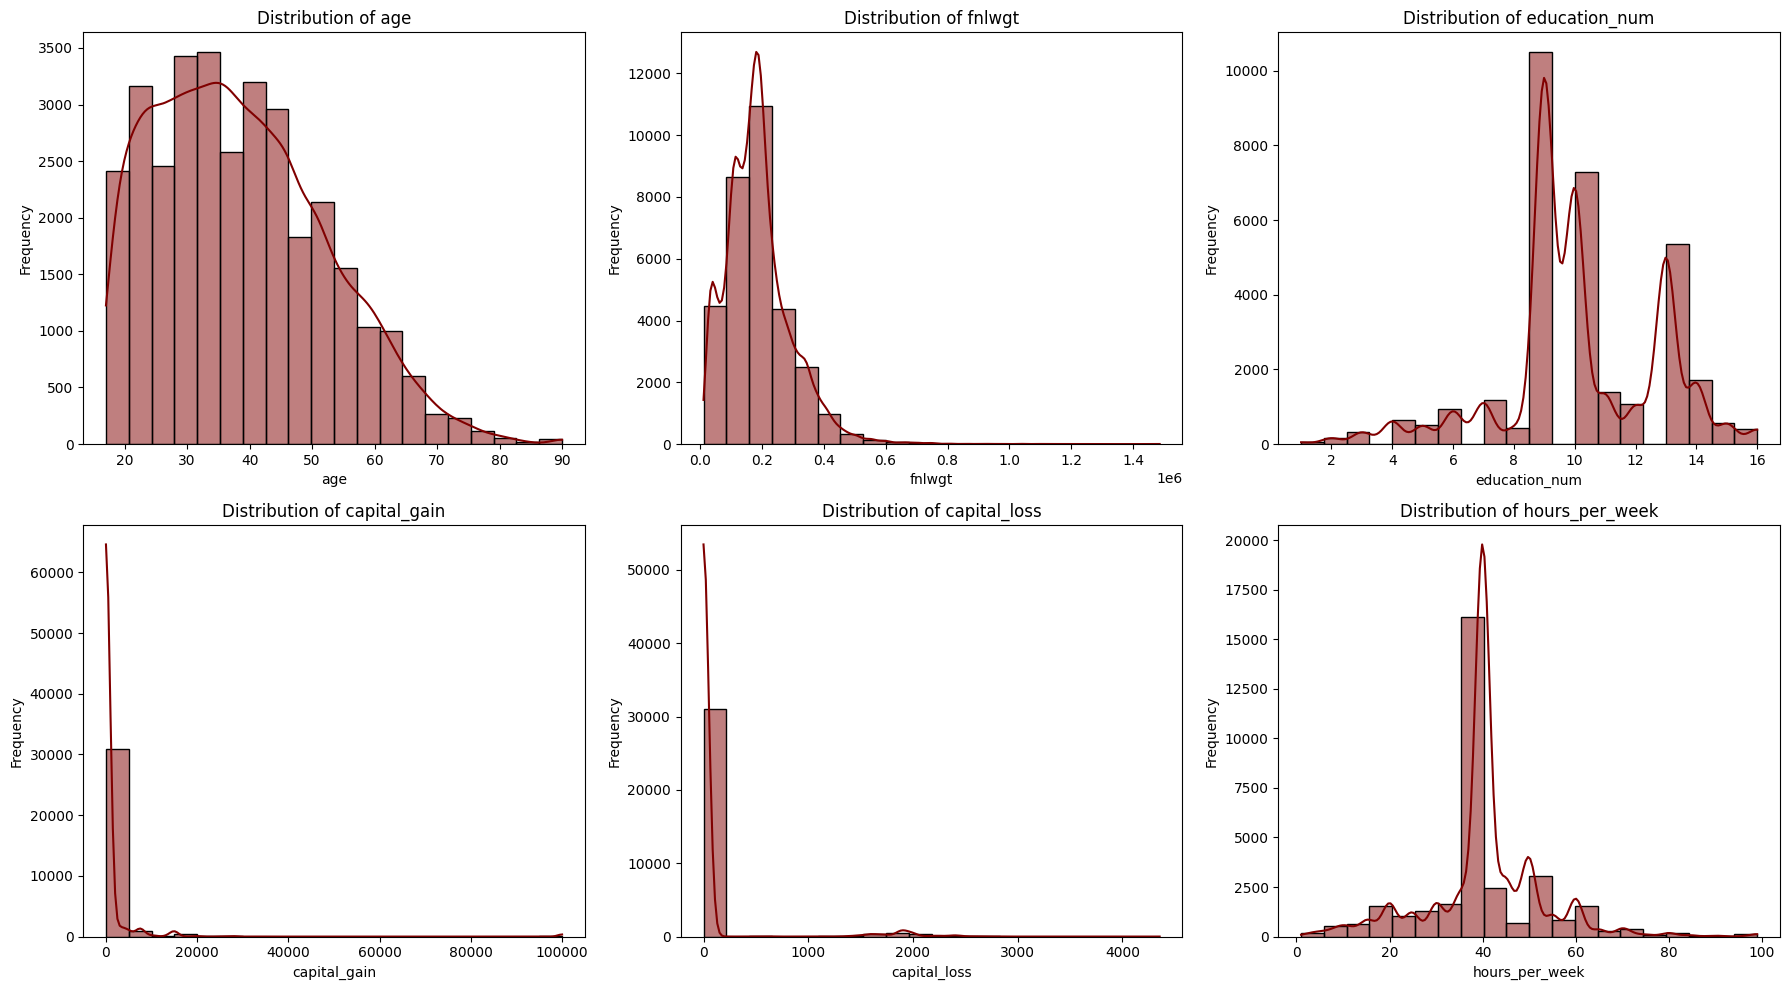

In [15]:
# Daftar kolom numerik yang ingin dianalisis
numeric_columns = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

# Membagi kolom menjadi dua kelompok (sesuai jumlah subplot yang tersedia)
group1 = numeric_columns[:3]  # Kolom pertama sampai ketiga
group2 = numeric_columns[3:]  # Kolom keempat sampai keenam

# Membuat figure dan axes untuk 2 baris dan 3 kolom
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 baris, 3 kolom

# Looping untuk kelompok pertama
for i, column in enumerate(group1):
    # Mengambil kolom dari PySpark DataFrame dan mengonversinya ke Pandas DataFrame
    data = df.select(column).toPandas()

    # Membuat histogram dan KDE (Kernel Density Estimation)
    sns.histplot(data[column], kde=True, ax=axes[i//3, i%3], color="maroon", bins=20)
    axes[i//3, i%3].set_title(f"Distribution of {column}")
    axes[i//3, i%3].set_xlabel(column)
    axes[i//3, i%3].set_ylabel("Frequency")

# Looping untuk kelompok kedua
for i, column in enumerate(group2):
    # Mengambil kolom dari PySpark DataFrame dan mengonversinya ke Pandas DataFrame
    data = df.select(column).toPandas()

    # Membuat histogram dan KDE
    sns.histplot(data[column], kde=True, ax=axes[(i+3)//3, (i+3)%3], color="maroon", bins=20)
    axes[(i+3)//3, (i+3)%3].set_title(f"Distribution of {column}")
    axes[(i+3)//3, (i+3)%3].set_xlabel(column)
    axes[(i+3)//3, (i+3)%3].set_ylabel("Frequency")

# Menampilkan grafik
plt.tight_layout()
plt.show()

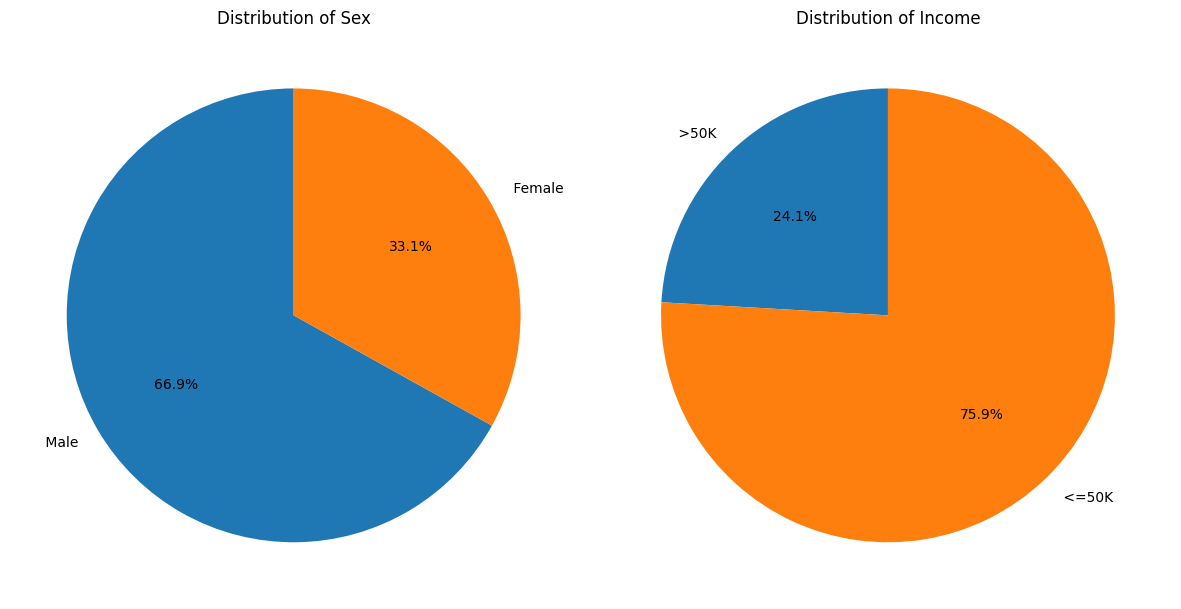

In [16]:
# Daftar kolom yang ingin dianalisis dengan pie chart
categorical_columns = ['sex', 'income']

# Membuat figure untuk pie chart
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 baris, 2 kolom

# Looping untuk kolom sex dan income
for i, column in enumerate(categorical_columns):
    # Mengambil kolom dari PySpark DataFrame dan mengonversinya ke Pandas DataFrame
    counts = df.groupBy(column).count()
    counts_pd = counts.toPandas()

    # Membuat pie chart
    axes[i].pie(counts_pd['count'], labels=counts_pd[column], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f"Distribution of {column.capitalize()}")

# Menampilkan grafik
plt.tight_layout()
plt.show()

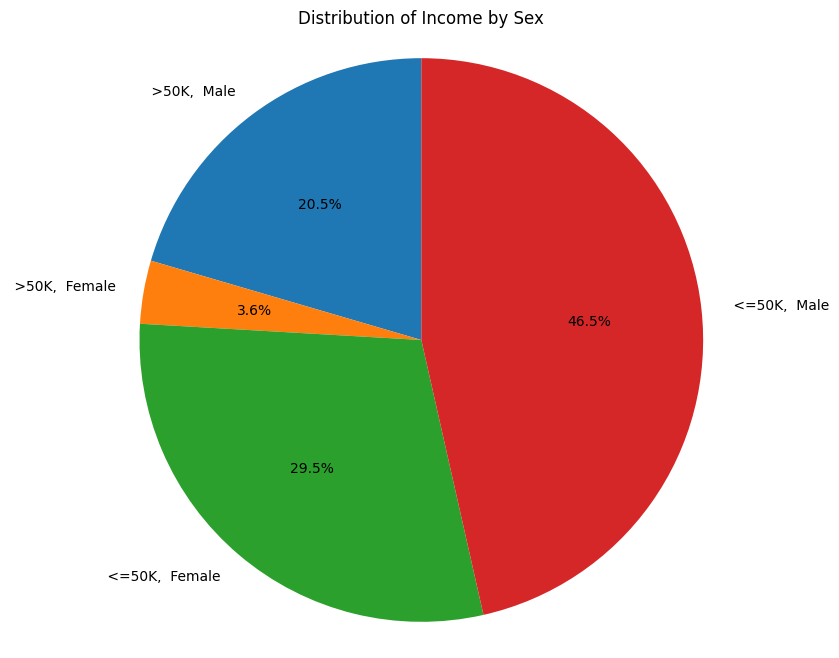

In [17]:
# Assuming 'df' is your Spark DataFrame
income_sex_counts = df.groupBy("income", "sex").count().toPandas()

# Create the pie chart
plt.figure(figsize=(8, 8))  # Adjust figure size as needed
plt.pie(income_sex_counts['count'], labels=[f"{income}, {sex}" for income, sex in zip(income_sex_counts['income'], income_sex_counts['sex'])], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Income by Sex')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# **Transformasi**

In [18]:
# Tentukan kolom kategorik, termasuk kolom 'sex'
categorical_columns = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'native_country', 'income', 'sex']

# Loop untuk melakukan Label Encoding menggunakan StringIndexer
for column in categorical_columns:
    indexer = StringIndexer(inputCol=column, outputCol=column + "_indexed")
    df = indexer.fit(df).transform(df)

# Menampilkan hasil transformasi
# df.select(categorical_columns + [col + "_indexed" for col in categorical_columns]).show(5)
# Menghapus kolom asli setelah proses encoding
columns_to_drop = categorical_columns
df = df.drop(*columns_to_drop)

# Menampilkan hasil transformasi
df.show(5)

+---+------+-------------+------------+------------+--------------+-----------------+-----------------+----------------------+------------------+--------------------+------------+----------------------+--------------+-----------+
|age|fnlwgt|education_num|capital_gain|capital_loss|hours_per_week|workclass_indexed|education_indexed|marital_status_indexed|occupation_indexed|relationship_indexed|race_indexed|native_country_indexed|income_indexed|sex_indexed|
+---+------+-------------+------------+------------+--------------+-----------------+-----------------+----------------------+------------------+--------------------+------------+----------------------+--------------+-----------+
| 39| 77516|           13|        2174|           0|            40|              4.0|              2.0|                   1.0|               3.0|                 1.0|         0.0|                   0.0|           0.0|        0.0|
| 50| 83311|           13|           0|           0|            13|             